# Project: Solid state

## Question 1

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.fft import fft, ifft, fftfreq

/var/folders/zx/ck7rkn5j0_zfqqnb92k3668r0000gn/T/ipykernel_65828/1763007083.py:14: RuntimeWarning: divide by zero encountered in divide
  wavelengths = c / freq


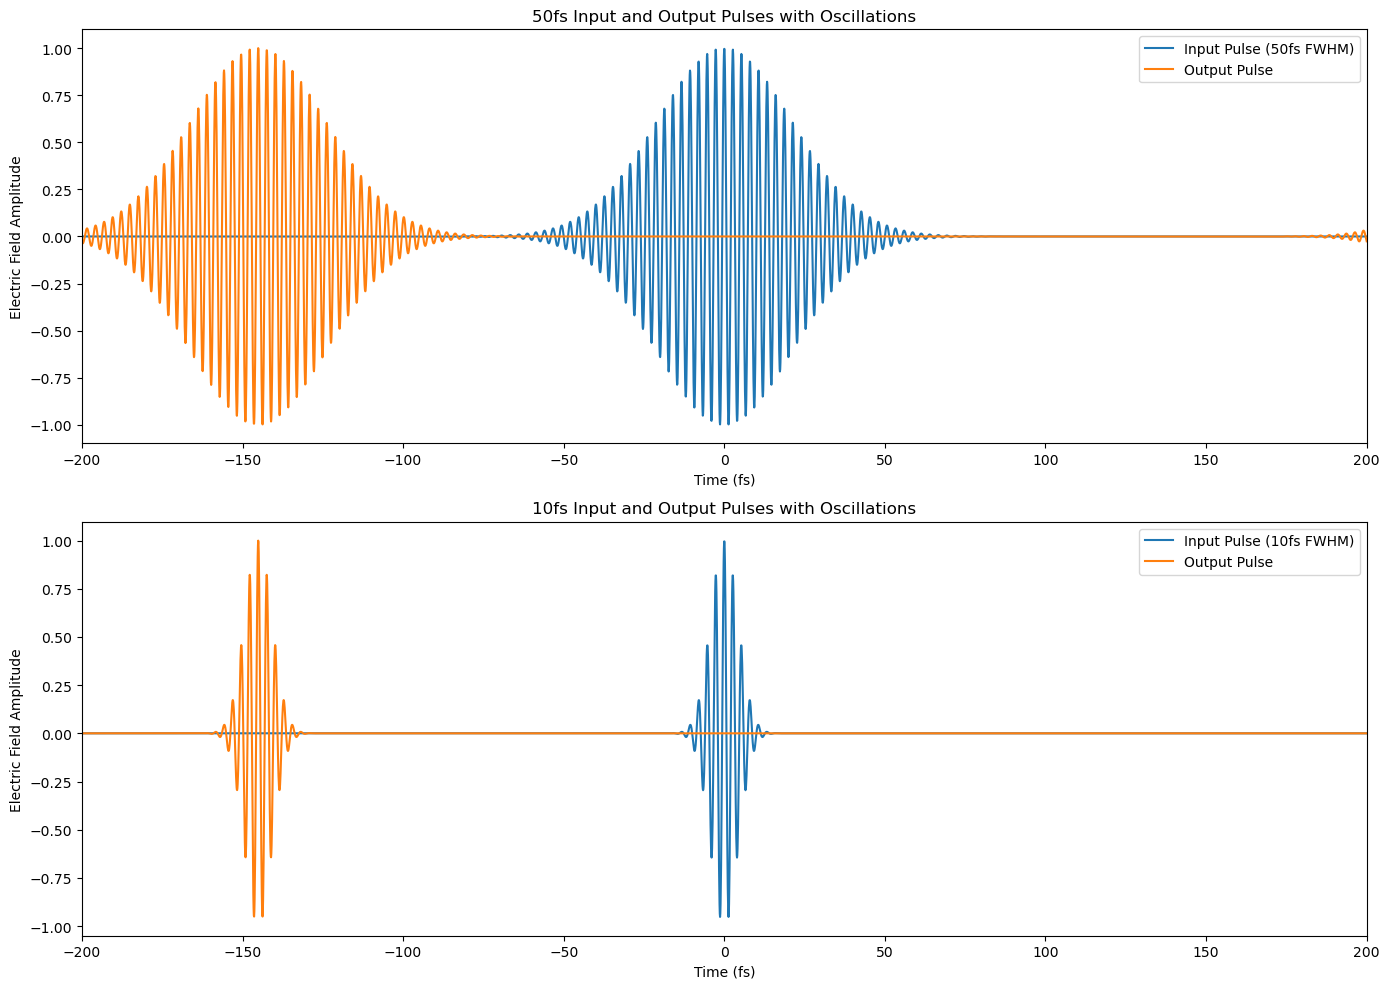

In [11]:
# Constants
c = 3e8  # speed of light in vacuum, m/s
central_wavelength = 800e-9  # central wavelength in meters
central_frequency = c / central_wavelength  # central frequency in Hz

# Time domain setup
time_window = 400e-15  # 400 fs total time window
time_steps = 5000  # number of time steps
t = np.linspace(-time_window / 2, time_window / 2, time_steps)
dt = t[1] - t[0]  # time step size

# Frequency domain setup
freq = fftfreq(time_steps, dt)
wavelengths = c / freq

# Sapphire properties for dispersion, assuming no dispersion for simplicity
n_sapphire = 1.76  # refractive index of sapphire at 800nm

# Function to create a Gaussian pulse with an oscillating component
def gaussian_pulse_oscillating(t, fwhm, central_frequency, amplitude=1):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    envelope = amplitude * np.exp(-(t**2) / (2 * sigma**2))
    oscillation = np.cos(2 * np.pi * central_frequency * t)
    return envelope * oscillation

# Create two Gaussian pulses with different FWHMs and include the oscillating component
pulse_50fs = gaussian_pulse_oscillating(t, 50e-15, central_frequency)
pulse_10fs = gaussian_pulse_oscillating(t, 10e-15, central_frequency)

# Fourier Transform to frequency domain
pulse_50fs_freq = fft(pulse_50fs)
pulse_10fs_freq = fft(pulse_10fs)

# Function to apply the phase shift due to propagation through sapphire, unchanged
def apply_propagation(pulse_freq, thickness=1e-2):
    phase_shift = np.exp(-1j * (2 * np.pi * n_sapphire * thickness) / wavelengths)
    return pulse_freq * phase_shift

# Apply propagation through 1 cm of sapphire
propagated_50fs_freq = apply_propagation(pulse_50fs_freq)
propagated_10fs_freq = apply_propagation(pulse_10fs_freq)

# Inverse Fourier Transform back to time domain
propagated_50fs = ifft(propagated_50fs_freq)
propagated_10fs = ifft(propagated_10fs_freq)

# Plot the input and output pulses with oscillations
plt.figure(figsize=(14, 10))

# 50fs pulse
plt.subplot(2, 1, 1)
plt.title('50fs Input and Output Pulses with Oscillations')
plt.plot(t * 1e15, pulse_50fs.real, label='Input Pulse (50fs FWHM)')
plt.plot(t * 1e15, propagated_50fs.real, label='Output Pulse')
plt.xlabel('Time (fs)')
plt.ylabel('Electric Field Amplitude')
plt.legend()
plt.xlim(-200, 200)

# 10fs pulse
plt.subplot(2, 1, 2)
plt.title('10fs Input and Output Pulses with Oscillations')
plt.plot(t * 1e15, pulse_10fs.real, label='Input Pulse (10fs FWHM)')
plt.plot(t * 1e15, propagated_10fs.real, label='Output Pulse')
plt.xlabel('Time (fs)')
plt.ylabel('Electric Field Amplitude')
plt.legend()
plt.xlim(-200, 200)

plt.tight_layout()
plt.savefig('proj_images/1.pdf')
plt.show()


## Question 4

In [6]:
import pandas as pd

In [7]:
# data from table 2
data = {
    'lambda': [10140, 8943.5, 8521.2, 8189.0, 6438.5, 5893.0, 5790.7, 5460.7, 
               5085.8, 4799.9, 4678.2, 4358.3, 4046.6],
    'ne': [1.54333, 1.54469, 1.54542, 1.54589, 1.55012, 1.55247, 1.55298, 1.55465,
           1.55691, 1.55914, 1.56024, 1.56376, 1.56796],
    'no': [1.65608, 1.65862, 1.65969, 1.66066, 1.66736, 1.67049, 1.67131, 1.67376,
           1.67722, 1.68044, 1.68198, 1.68679, 1.69267]
}

# Converting the dictionary to a DataFrame
df = pd.DataFrame(data)
df.head()

,lambda,ne,no
0,10140.0,1.54333,1.65608
1,8943.5,1.54469,1.65862
2,8521.2,1.54542,1.65969
3,8189.0,1.54589,1.66066
4,6438.5,1.55012,1.66736


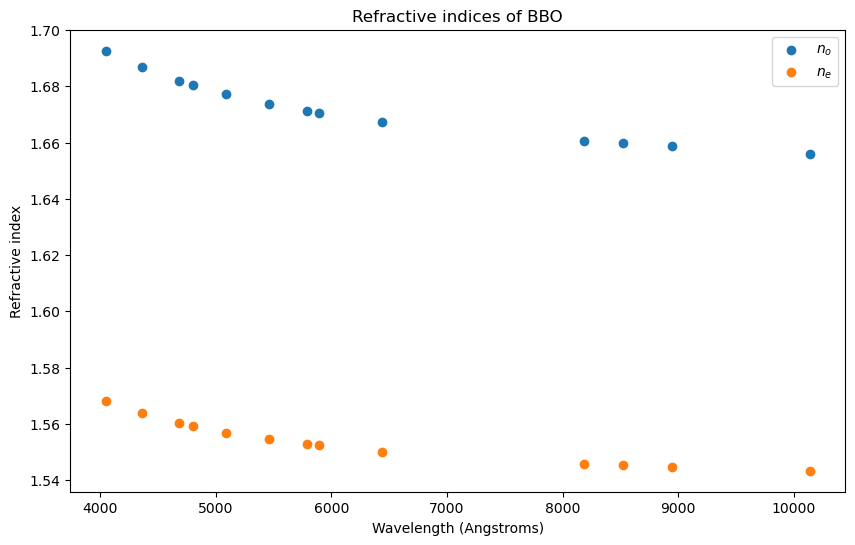

In [49]:
# part e, make a plot of ne and no vs wavelength
plt.figure(figsize=(10, 6))
plt.scatter(df['lambda'], df['no'], label='$n_o$')
plt.scatter(df['lambda'], df['ne'], label='$n_e$', )

plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Refractive index')
plt.title('Refractive indices of BBO')
plt.savefig('proj_images/2e.pdf')

In [36]:
# Sellmeier equation for BBO
def sellmeier(lambda_, A, B, C, D):
    return A + B/(lambda_**2+C) + D*lambda_**2

# Fit the Sellmeier equation to the data
from scipy.optimize import curve_fit

# Fit the Sellmeier equation to the ne data
ne2 = df['ne']**2
popt_ne, pcov_ne = curve_fit(sellmeier, df['lambda'], ne2)
A_ne, B_ne, C_ne, D_ne = popt_ne
ne_fit = np.sqrt(sellmeier(df['lambda'], A_ne, B_ne, C_ne, D_ne))

# get residuals
residuals_ne = ne2 - sellmeier(df['lambda'], A_ne, B_ne, C_ne, D_ne)
chi2_ne_red = np.sum(residuals_ne**2) / (len(df['lambda']) - 4)


# Fit the Sellmeier equation to the no data
no2 = df['no']**2
popt_no, pcov_no = curve_fit(sellmeier, df['lambda'], no2)
A_no, B_no, C_no, D_no = popt_no
no_fit = np.sqrt(sellmeier(df['lambda'], A_no, B_no, C_no, D_no))

# get residuals
residuals_no = no2 - sellmeier(df['lambda'], A_no, B_no, C_no, D_no)
chi2_no_red = np.sum(residuals_no**2) / (len(df['lambda']) - 4)

In [37]:
# print out the fit parameters
print(f'ne fit parameters: A={A_ne}, B={B_ne}, C={C_ne}, D={D_ne}')
print(f'no fit parameters: A={A_no}, B={B_no}, C={C_no}, D={D_no}')
ne_err = np.sqrt(np.diag(pcov_ne))
no_err = np.sqrt(np.diag(pcov_no))
# put them in df with uncertainty
df_coeffs = pd.DataFrame({'ne': [A_ne, B_ne, C_ne, D_ne], 'ne_err': ne_err, 'no': [A_no, B_no, C_no, D_no], 'no_err': no_err}, index=['A', 'B', 'C', 'D'])
df_coeffs

ne fit parameters: A=2.3740201751290737, B=1221473.4754177548, C=-2026694.5191651527, D=-4.28628744330316e-11
no fit parameters: A=2.737272701978342, B=1927510.5810058687, C=-1552343.858979478, D=-1.3402190594926053e-10


,ne,ne_err,no,no_err
A,2.374020e+00,1.750074e-03,2.737273e+00,7.880217e-04
B,1.221473e+06,5.685340e+04,1.927511e+06,2.625565e+04
C,-2.026695e+06,4.392527e+05,-1.552344e+06,1.318990e+05
D,-4.286287e-11,1.381631e-11,-1.340219e-10,6.155366e-12


In [41]:
(1e-4)**2

1e-08

In [44]:
(1e-4)**2*1e6

0.01

In [42]:
(1e-4)**(-2)

99999999.99999999

In [43]:
(1e-4)**(-2)*1e-11

0.0009999999999999998

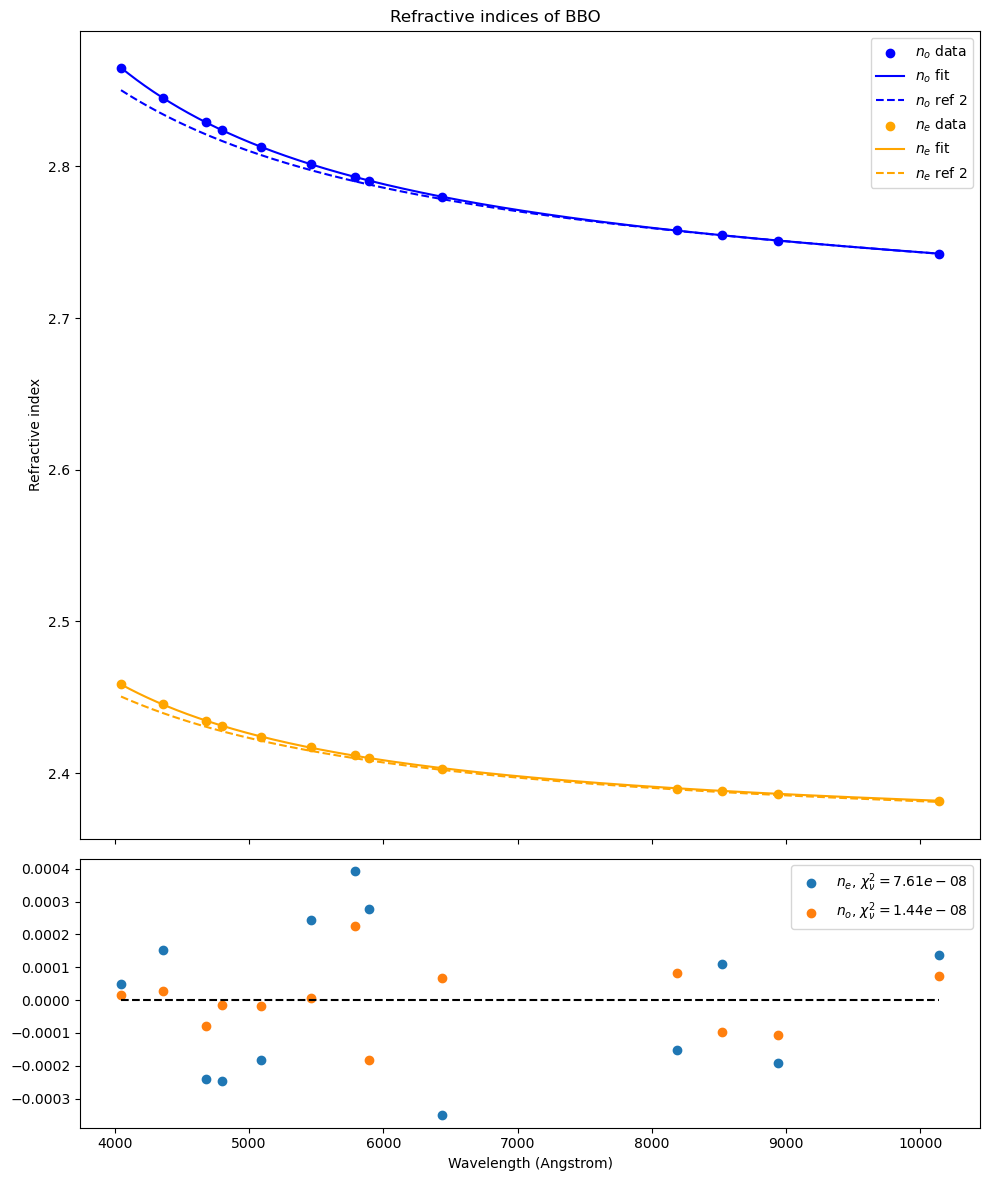

In [50]:
# Plot the fit

# get linspace
linspace = np.linspace(df['lambda'].min(), df['lambda'].max(), 1000)

# plot with residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

ax[0].scatter(df['lambda'], df['no']**2, label='$n_o$ data', color='blue')
ax[0].plot(linspace, sellmeier(linspace, A_no, B_no, C_no, D_no), label='$n_o$ fit', color='blue')
ax[0].plot(linspace, sellmeier(linspace, 2.7405, 0.0184*(1e-4)**(-2), -0.0179*(1e-4)**(2), -0.0155*(1e-4)**(2)), label='$n_o$ ref 2', linestyle='--', color='blue')

ax[0].scatter(df['lambda'], df['ne']**2, label='$n_e$ data', color='orange')
ax[0].plot(linspace, sellmeier(linspace, A_ne, B_ne, C_ne, D_ne), label='$n_e$ fit', color='orange')
ax[0].plot(linspace, sellmeier(linspace, 2.3730, 0.0128*(1e-4)**(-2), -0.0156*(1e-4)**(2), -0.0044*(1e-4)**(2)), label='$n_e$ ref 2', linestyle='--', color='orange')


# compare to actual fit params
# ne: 2.3730 0.0128 - 0.0156 -0.0044
# no: 2.7405 0.0184 - 0.0179 - 0.0155



ax[0].legend()
ax[0].set_ylabel('Refractive index')

ax[1].scatter(df['lambda'], residuals_ne, label='$n_e$, $\chi^2_{\\nu} = %.3g$'%(chi2_ne_red))
ax[1].scatter(df['lambda'], residuals_no, label='$n_o$, $\chi^2_{\\nu} = %.3g$'%(chi2_no_red))
ax[1].hlines(0, df['lambda'].min(), df['lambda'].max(), color='black', linestyle='--')
ax[1].legend()
ax[1].set_xlabel('Wavelength (Angstrom)')

plt.suptitle('Refractive indices of BBO')
plt.tight_layout()
plt.savefig('proj_images/2f.pdf')

### math for problem 2

In [52]:
from scipy.constants import pi, c

# Given values
tau = 100e-15  # 100 femtoseconds
nu_0 = 3e14    # 3*10^14 Hz
lambda_0 = c / nu_0  # Central wavelength of the pulse spectrum
n_2 = 1e-19    # m^2/W
z = 1          # Propagation distance in air is 1 meter

# Bandwidth calculation
# FWHM in time domain
fwhm_time = 2 * tau * (2 * np.log(2))**0.5
# FWHM in frequency domain (using the time-bandwidth product for a Gaussian pulse)
fwhm_freq = (1 / (2 * pi)) * (2 * (2 * np.log(2))**0.5) / tau

# Part 2 calculations
# Spectral width due to SPM
# We approximate the change in phase over the pulse width in time
delta_phi = 2 * pi * n_2 * z / lambda_0  # Phase shift per unit intensity
delta_nu_spm = (1 / (2 * pi)) * (delta_phi / fwhm_time)  # Approximate frequency width due to SPM per unit intensity

# The threshold intensity I_0 for spectral broadening occurs when delta_nu_spm equals the bandwidth of the pulse
threshold_intensity = fwhm_freq / delta_nu_spm

fwhm_freq, 2*pi / fwhm_time, threshold_intensity

(3747812502585.552, 26682231283184.98, 8819318518942.48)

### math for problem 3

In [55]:
# Given typical values
d_eff = 1e-12  # m/V
lambda_p = 400e-9  # Wavelength of pump (400 nm)
epsilon_0 = 8.854187817e-12  # Permittivity of free space (F/m)

# Calculate angular frequencies
nu_p = c / lambda_p  # Frequency of pump (Hz)
omega_p = 2 * pi * nu_p  # Angular frequency of pump (rad/s)
# For degenerate SPDC, we assume omega_s = omega_i = omega_p / 2
omega_s = omega_p / 2  # Angular frequency of signal (rad/s)
omega_i = omega_p / 2  # Angular frequency of idler (rad/s)

# Interaction volume V, assuming a beam waist of 100 micrometers and crystal length of 1 mm
radius = 50e-6  # Beam waist radius (m)
length = 1e-3  # Crystal length (m)
V = pi * (radius ** 2) * length  # Interaction volume (m^3)

# Calculate the coupling constant kappa
kappa = (2 * d_eff / (3 * epsilon_0 * V)) * ((omega_p * omega_s * omega_i) / (2 * epsilon_0 * V))**0.5
kappa

1.3134595428473106e+44

In [56]:
V

7.853981633974482e-12